## Length of the report {-}
The length of the report must be no more than 15 pages, when printed as PDF. However, there is no requirement on the minimum number of pages.

You may put additional stuff as Appendix. You may refer to the Appendix in the main report to support your arguments. However, your appendix is unlikely to be checked while grading, unless the grader deems it necessary. The appendix and references will not be included in the page count, and there is no limit on the length of the appendix.

**Delete this section from the report, when using this template.** 

In [2]:
#| echo: false
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
import statsmodels.api as sm
from statsmodels.formula.api import ols
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

pd.set_option('display.max_columns', 100)
OnlineNewsPopularity = pd.read_csv("OnlineNewsPopularity.csv")

## Background / Motivation

We were motivated to work on this problem due to our generation primarily receiving news from online media sources and other forms of social media. We recognized that not all news is shared equally, however, and we wanted to understand the features that determine the popularity of news articles published online.

## Problem statement 

We want to understand the factors underlying online news popularity and predict whether or not articles will be popular based on specific features inherent to each article prior to publication.

## Data sources

Our dataset contains information about articles published by the news outlet Mashable in a period of two years. The response variable is the number of shares each article has accumulated, and there are 58 predictive attributes that include factors such as word count, keyword count, publication day of the week, and topic. As a result, the dataset is a good resource for exploring the factors that may underlie the popularity of news articles. The dataset can be found on the University of California, Irvine’s machine learning repository. 

The data can be found here: https://archive.ics.uci.edu/dataset/332/online+news+popularity

## Stakeholders

Our stakeholders are online publications and writers for such platforms. Because the metric of success in the literary world is popularity, both the platform and the writer seek to maximize the number of readers their articles will receive. As a result, by successfully predicting the popularity of a news article, they will be able to better gauge what types of articles are likely to receive more engagement; thus they should put more effort into those articles for better returns. 

## Data quality check / cleaning / preparation 

The distribution of our binary response variable is shown below. The process by which we created this variable is described later in the report.

In [8]:
#| echo: false

from skimpy import clean_columns
data = clean_columns(OnlineNewsPopularity)


data.iloc[data.n_unique_tokens.argmax()]
data.iloc[31037].n_non_stop_words
data.iloc[31037].n_non_stop_unique_tokens
data.iloc[31037, data.columns.get_loc('n_unique_tokens')] = data.n_unique_tokens[31037]/data.n_tokens_content[31037]
data.iloc[31037, data.columns.get_loc('n_non_stop_words')] = data.n_non_stop_words[31037]/data.n_tokens_content[31037]
data.iloc[31037, data.columns.get_loc('n_non_stop_unique_tokens')] = data.n_non_stop_unique_tokens[31037]/data.n_tokens_content[31037]

data['avg_shares_per_day'] = data['shares']/data['timedelta']

data['popular'] = data.avg_shares_per_day.apply(lambda x: 1 if x > np.median(data.avg_shares_per_day)
                                    else 0)

print('Proportion of 1s:', np.mean(data.popular))
print('Proportion of 0s:', 1-np.mean(data.popular))

60 column names have been cleaned

Proportion of 1s: 0.5
Proportion of 0s: 0.5


The distributions of our predictors are shown below as well. 

In [23]:
#| echo: false
data_cat = data.copy()
data_cat['day'] = data_cat.apply(lambda x: 'Sunday' if x['weekday_is_sunday'] == 1
                                    else 'Monday' if x['weekday_is_monday'] == 1
                                    else 'Tuesday' if x['weekday_is_tuesday'] == 1
                                    else 'Wednesday' if x['weekday_is_wednesday'] == 1
                                    else 'Thursday' if x['weekday_is_thursday'] == 1
                                    else 'Friday' if x['weekday_is_friday'] == 1
                                    else 'Saturday', axis = 1)

data_cat['data_channel'] = data_cat.apply(lambda x: 'lifestyle' if x['data_channel_is_lifestyle'] == 1
                                             else 'tech' if x['data_channel_is_tech'] == 1
                                             else 'socmed' if x['data_channel_is_socmed'] == 1
                                             else 'entertainment' if x['data_channel_is_entertainment'] == 1
                                             else 'bus' if x['data_channel_is_bus'] == 1
                                             else 'world', axis = 1)

print(data_cat.day.value_counts())

Wednesday    7435
Tuesday      7390
Thursday     7267
Monday       6661
Friday       5701
Sunday       2737
Saturday     2453
Name: day, dtype: int64


In [24]:
#| echo: false
print(data_cat.data_channel.value_counts())

world            14561
tech              7346
entertainment     7057
bus               6258
socmed            2323
lifestyle         2099
Name: data_channel, dtype: int64


In [26]:
#| echo: false
dummies = [col for col in data.columns if 'is' in col]
data_num = data.drop(dummies, axis = 1)

In [28]:
#| echo: false
data_num.iloc[:,0:10].describe()

,timedelta,n_tokens_title,n_tokens_content,n_unique_tokens,n_non_stop_words,n_non_stop_unique_tokens,num_hrefs,num_self_hrefs,num_imgs
count,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000
mean,354.530471,10.398749,546.514731,0.530545,0.970201,0.672790,10.883690,3.293638,4.544143
std,214.163767,2.114037,471.107508,0.137111,0.170017,0.154039,11.332017,3.855141,8.309434
min,8.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,164.000000,9.000000,246.000000,0.470858,1.000000,0.625720,4.000000,1.000000,1.000000
50%,339.000000,10.000000,409.000000,0.539216,1.000000,0.690476,8.000000,3.000000,1.000000
75%,542.000000,12.000000,716.000000,0.608696,1.000000,0.754620,14.000000,4.000000,4.000000
max,731.000000,23.000000,8474.000000,1.000000,1.000000,1.000000,304.000000,116.000000,128.000000


In [29]:
#| echo: false
data_num.iloc[:,10:20].describe()

,num_videos,average_token_length,num_keywords,kw_min_min,kw_max_min,kw_avg_min,kw_min_max,kw_max_max,kw_avg_max,kw_min_avg
count,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000
mean,1.249874,4.548239,7.223767,26.106801,1153.951682,312.366967,13612.354102,752324.066694,259281.938083,1117.146610
std,4.107855,0.844406,1.909130,69.633215,3857.990877,620.783887,57986.029357,214502.129573,135102.247285,1137.456951
min,0.000000,0.000000,1.000000,-1.000000,0.000000,-1.000000,0.000000,0.000000,0.000000,-1.000000
25%,0.000000,4.478404,6.000000,-1.000000,445.000000,141.750000,0.000000,843300.000000,172846.875000,0.000000
50%,0.000000,4.664082,7.000000,-1.000000,660.000000,235.500000,1400.000000,843300.000000,244572.222223,1023.635611
75%,1.000000,4.854839,9.000000,4.000000,1000.000000,357.000000,7900.000000,843300.000000,330980.000000,2056.781032
max,91.000000,8.041534,10.000000,377.000000,298400.000000,42827.857143,843300.000000,843300.000000,843300.000000,3613.039819


In [30]:
#| echo: false
data_num.iloc[:,20:30].describe()

,kw_max_avg,kw_avg_avg,self_reference_min_shares,self_reference_max_shares,self_reference_avg_sharess,lda_00,lda_01,lda_02,lda_03,lda_04
count,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000
mean,5657.211151,3135.858639,3998.755396,10329.212662,6401.697580,0.184599,0.141256,0.216321,0.223770,0.234029
std,6098.871957,1318.150397,19738.670516,41027.576613,24211.332231,0.262975,0.219707,0.282145,0.295191,0.289183
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3562.101631,2382.448566,639.000000,1100.000000,981.187500,0.025051,0.025012,0.028571,0.028571,0.028574
50%,4355.688836,2870.074878,1200.000000,2800.000000,2200.000000,0.033387,0.033345,0.040004,0.040001,0.040727
75%,6019.953968,3600.229564,2600.000000,8000.000000,5200.000000,0.240958,0.150831,0.334218,0.375763,0.399986
max,298400.000000,43567.659946,843300.000000,843300.000000,843300.000000,0.926994,0.925947,0.919999,0.926534,0.927191


In [31]:
#| echo: false
data_num.iloc[:,30:40].describe()

,global_subjectivity,global_sentiment_polarity,global_rate_positive_words,global_rate_negative_words,rate_positive_words,rate_negative_words,avg_positive_polarity,min_positive_polarity,max_positive_polarity,avg_negative_polarity
count,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000
mean,0.443370,0.119309,0.039625,0.016612,0.682150,0.287934,0.353825,0.095446,0.756728,-0.259524
std,0.116685,0.096931,0.017429,0.010828,0.190206,0.156156,0.104542,0.071315,0.247786,0.127726
min,0.000000,-0.393750,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.000000
25%,0.396167,0.057757,0.028384,0.009615,0.600000,0.185185,0.306244,0.050000,0.600000,-0.328383
50%,0.453457,0.119117,0.039023,0.015337,0.710526,0.280000,0.358755,0.100000,0.800000,-0.253333
75%,0.508333,0.177832,0.050279,0.021739,0.800000,0.384615,0.411428,0.100000,1.000000,-0.186905
max,1.000000,0.727841,0.155488,0.184932,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000


In [34]:
#| echo: false
data_num.iloc[:,40:46].describe()

,min_negative_polarity,max_negative_polarity,title_subjectivity,title_sentiment_polarity,abs_title_subjectivity,abs_title_sentiment_polarity
count,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000
mean,-0.521944,-0.107500,0.282353,0.071425,0.341843,0.156064
std,0.290290,0.095373,0.324247,0.265450,0.188791,0.226294
min,-1.000000,-1.000000,0.000000,-1.000000,0.000000,0.000000
25%,-0.700000,-0.125000,0.000000,0.000000,0.166667,0.000000
50%,-0.500000,-0.100000,0.150000,0.000000,0.500000,0.000000
75%,-0.300000,-0.050000,0.500000,0.150000,0.500000,0.250000
max,0.000000,0.000000,1.000000,1.000000,0.500000,1.000000


When plotting the distributions of each predictor for our EDA, as will be shown in the next section, three were found to contain an error; while those predictors were all rates of specific occurrences and thus lay in the range of 0 to 1, the errant observation had values in the hundreds. Thus, we believed that the article’s information was input as the counts of the occurrences described by the predictors rather than the rates.

Based on the definition of the three predictors, we imputed the correct values of the observation by dividing the original values by the total word count of the article. Aside from that observation, the data was already cleaned and split into dummy variables.

There was a variable `timedelta` that described the number of days each article had been published for. Because it is not a variable that can be determined before publication, we decided it could not be used for our analysis. However, it is also very related to our response because the number of shares an article receives is related to the age of the article; after all, an article that has been published for a long time has a greater chance of accumulating shares. Thus, we created a new response variable, `avg_shares_per_day`, where we divided each article’s original number of shares by the number of days it was out for.
Using this new response variable, we created a binary classification variable called `popular`. If an article’s average shares per day was greater than the dataset’s median, it was considered popular; otherwise, it was not. 

We also performed variable selection using CatBoost. We fit the training data to a CatBoost classifier model with default hyperparameters and kept the top 80% of predictors in regards to feature importance. 


## Exploratory data analysis

EDA for this project helped both inform our decisions on how we would use both the response variables and the numerous predictors.

Our EDA first is used to separate continuous and categorical variables, which wasn’t always clear from the description of variables that the original dataset provided (like hidden categorical variables). We plotted every variable as a barplot, and once those graphs were plotted it was more clear which predictors were categorical (less bars as they focus more on categories. 

Second, we plotted the distribution of the response variable in its original state, shares. It showed an extreme left-skewed distribution, with only one or two outliers near the outer ranges of the range. This we hypothesized was due to the response variable not taking into account that one of the predictors, timedelta or time change, increases linearly like shares would over time, logically. Thus, we had looked to log this initially until we altered the response variable completely by dividing shares with timedelta, creating a much more uniform distribution. 

Third, we plotted the distribution of categorical predictors we found using barplots and the continuous predictors with boxplots, which we used to see if there were any extreme outliers. 

Finally, we plotted every predictor against the original response variable, shares, in order to see if, again, there were any abnormalities in the observations. Here, we found that there were 3 particular variables that seemed odd. ‘n_unique_tokens’, ‘n_non_stop_words’,  ‘n_non_stop_unique_tokens’, were all rate-based predictors, with almost all observations falling in between 0 and 1. However, there was a unique observation in all 3, around 700, which doesn;t make sense for a rate-based predictor. 

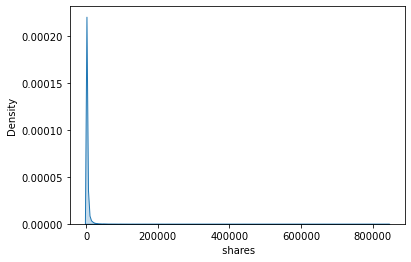

In [21]:
#| echo: false
clean = OnlineNewsPopularity.drop(['url'], axis = 1)
response_clean = clean[' shares']
sns.kdeplot(response_clean, fill=True, bw_method = .1);

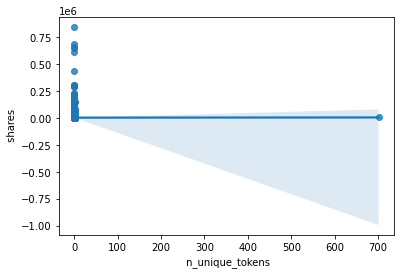

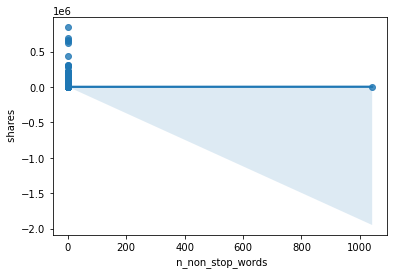

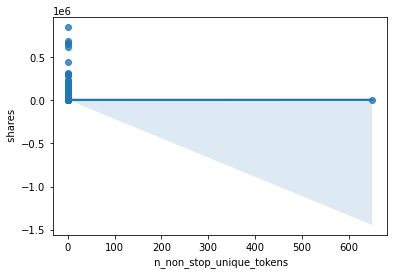

In [18]:
#| echo: false
cleaned = OnlineNewsPopularity.drop(['url'], axis = 1)
bad_tokens = cleaned.loc[:, [' n_unique_tokens', ' n_non_stop_words',  ' n_non_stop_unique_tokens', ' shares']]

for x in bad_tokens.columns:
    if x != ' shares':
        sns.regplot(x= x, y = ' shares', data = bad_tokens);
        plt.show()

We realized this may have been a  the observation may have been mis-observed or mislabeled, examining the true value instead of examining it as a rate. Thus, we solved this by simply dividing the observation by the total number of tokens and words later in data cleaning, which made these values rates again, which makes more sense in terms of the data.

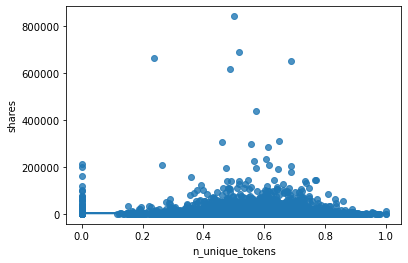

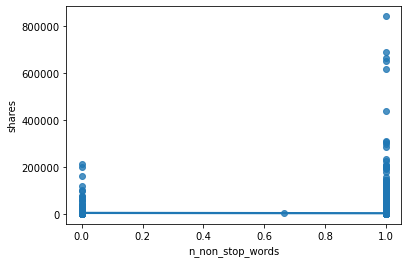

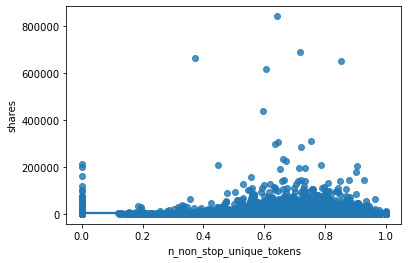

In [25]:
#| echo: false
good_tokens = data.loc[:, ['n_unique_tokens', 'n_non_stop_words', 'n_non_stop_unique_tokens', 'shares']]

for x in good_tokens.columns:
    if x != 'shares':
        sns.regplot(x= x, y = 'shares', data = good_tokens);
        plt.show()

## Approach

We used a number of binary classification models: Ridge/Lasso, Decision trees, Bagged models, Random Forest, Adaboost, Gradient Boosting, XGBoost, LightGBM, and Catboost. 

We chose to optimize accuracy and precision, though we focused primarily on precision by setting an accuracy threshold and finding the model with the best precision amongst the values that pass the accuracy threshold.  Writers most likely want to avoid investing time and effort into trying to create an article that goes unread, which corresponds to a false positive. Thus, we thought it was best to use precision as our primary performance metric. No particularly unorthodox methods were used.

We initially attempted to approach this project as a regression problem. We saw that this dataset had been used for classification before, so we wanted to see how well the number of shares could be predicted. While we anticipated that regression would not perform as well as binary classification, it was even more difficult than we expected to lower the RMSE from the base models, regardless of how thoroughly we tuned individual models. 

It is possible that the response variable is not thoroughly explained by the predictors; popularity of writing in general is always hard to predict because there are always articles that "should" be popular but end up receiving little attention. Such factors could include the time of day during which the article was published, website algorithms that could promote certain articles based on current events, or most significantly, the whimsicality of human nature—none of which are encapsulated by the dataset. 

Whereas existing Kaggle solutions tend to approach this problem as a binary classification of popularity based on total shares (our original dataset), we decided to define popularity as the average shares an article received per day, as described above (our modified dataset). Thus, we did not build upon existing solutions, and it is difficult to compare results, as the responses are different. However, we believe our definition is more in line with the wishes of our stakeholders, as time is a predictor that naturally increases shares.

## Developing the model: Hyperparameter tuning

Every person must describe their hyperparameter tuning procedure. Show the grid of hyperparameter values over which the initial search was done *(you may paste your grid search / random search / any other search code)*, and the optimal hyperparameter values obtained. After getting the initial search results, how did you make decisions *(if any)* to further fine-tune your model. Did you do another grid / random search or did you tune hyperparameters sequentially? If you think you didn't need any fine tuning after the initial results, then mention that and explain why.

Put each model in a section of its name and mention the name of the team-member tuning the model. Below is an example:

### Adaboost, LightBGM, & Catboost
*By Daniel He*

Regarding Adaboost, the base model was not accurate at all compared to some of our other base models, with accuracy only reaching around 0.660865 and precision only around 0.656234. Due to our project’s circumstances and tight deadline, I tuned hyperparameters solely with a few grids and light hand-tuning. I tuned with this grid first: 


In [ ]:
grid['n_estimators'] = [10, 50, 100,200,500, 1000]
grid['learning_rate'] = [0.001, 0.01,0.1, 0.5, 1.0]
grid['base_estimator'] = [DecisionTreeClassifier(max_depth=1), DecisionTreeClassifier(max_depth=10), DecisionTreeClassifier(max_depth=15),DecisionTreeClassifier(max_depth=20)]

With that initial grid, both accuracy and precision jumped a lot, with accuracy increasing to 0.742212, and precision increasing to 0.723581 with base_estimator=DecisionTreeClassifier(max_depth=10), learning_rate=0.01, random_state = 1, n_estimators=1000. Further grids, where I focused in on all hyperparameters, didn't do much for accuracy and precision, so I began tuning hyperparameters sequentially, starting with ‘n_estimators’. After tuning this parameter only with the grid: 

In [ ]:
grid[‘n_estimators’] = [90, 100, 150, 200, 250, 300, 350, 400]

I then found that 100 was the closest to the most ideal ‘n_estimators’ hyperparameter, which gave the highest accuracy and precision, with accuracy =  0.750536 and precision = 0.730106 from final hyperparameters being:

In [ ]:
AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=10), learning_rate=0.01, 
                   random_state = 1, n_estimators=100).fit(X_train_scaled, y_train)

I then began tuning for the ideal threshold, using cross_val_score with 2-fold to save on computation time, to find that 0.61 was approximately the ideal threshold, which further increased both accuracy and precision, so accuracy = 0.7674359 and precision = 0.7976564. Train test and accuracy were both around 0.84 to 0.86, so this model didn’t overfit the training data as much as some of the other tree-based models.

I followed this similar procedure for LightGBM, for which I first tuned hyperparameters on:

In [ ]:
param_grid = {'max_depth': [4,6,8],
              'num_leaves': [20, 31, 40],
              'learning_rate': [0.01, 0.05, 0.1],
               'reg_lambda':[0, 10, 100],
                'n_estimators':[100, 500, 1000],
                'reg_alpha': [0, 10, 100],
                'subsample': [0.5, 0.75, 1.0]}

This increased both accuracy and precision by approximately 0.01, to which I further hand-tuned ‘n_estimators’ to 2000 estimators, but hand tuning other hyperparameters tuned did not improve performance.

This increased both accuracy and precision to 0.77033 and 0.7598716 approximately. Then, I tuned for threshold, finding that 0.56 maximizes both accuracy and precision, 0.770967 and 0.786587 respectively, though precision was increased more dramatically by almost 3%. 

For Catboost, since it is so accurate from default hyperparameters already, I focused mainly on tuning for decision threshold. Here, I found that 0.52 has the best balance between accuracy and threshold without significantly compromising one or the other, increasing accuracy from 0.77109345 to 0.7717241 and precision from 0.76242545 to 0.7709239. 

### Random forest, Gradient boosting, & XGBoost
*By Sarah Hsu*

The base model for a random forest classifier yielded a test accuracy of 0.7567 and a precision of  0.7387. Due to our project’s circumstances and tight deadline, I tuned hyperparameters solely with grids. After standardizing the predictors, I first used the coarse tuning grid below:

In [ ]:
params = {'n_estimators': [250, 500, 750],
          'max_depth':[10, 15, 20, 25],
         'min_samples_split': [5, 10, 20, 40]}

After running through the first tuning grid of my random forest model, I noticed that both accuracy and precision seemed to continue to increase past the tested range of max depth. Therefore, I did another grid search with a range of max depth that had greater values, shown below. I also narrowed the range for min samples split to test the values closer to the optimal value of 5 from the first grid.

In [ ]:
params = {'n_estimators': [500, 750, 1000],
          'max_depth':[25, 30, 35],
         'min_samples_split': [3, 5, 6, 7]}

My best parameters were a max depth of 35, a min sample split of 6, and 750 estimators. Then, I tested for the optimal threshold, holding accuracy at a minimum of 0.75 and identifying the threshold value that would return the highest precision. A decision threshold of 0.61 returned a test accuracy of 0.7566 and precision of 0.8045. In comparison to the base model, the accuracy is about the same, and the precision has increased after hyperparameter tuning.

The gradient boosting base model had slightly better performance than the random forest model, with an accuracy of 0.7618 and a precision of 0.7444. For my first tuning grid, I used a randomized search because of the greater amount of time it takes. 

In [ ]:
params = {'n_estimators': [500, 750, 1000],
          'learning_rate':[0.01, 0.1, 1.0],
          'max_depth':[2, 5, 10],
         'min_samples_split': [2, 5, 8],
         'subsample':[0.25, 0.5, 0.75, 1.0]}

I noticed that a large learning rate was detrimental to model performance and that there seemed to be an increase in model performance with high max depth, though a much slighter one than observed with a random forest model. As a result, for a finer tuning grid, the values for model depth were increased slightly. I also narrowed down the values for both learning rate and subsample, as shown below.

In [ ]:
params = {'n_estimators': [500, 750, 1000],
          'learning_rate':[0.01, 0.05, 0.1],
          'max_depth':[8, 10, 12],
         'min_samples_split': [2, 5, 8],
         'subsample':[0.5, 0.6, 0.7, 0.8]}

The best hyperparameters were a subsample of 0.6, 750 estimators, a minimum sample split of 5, a max depth of 10, and a learning rate of 0.01. I then found that the optimal decision threshold, holding the minimum accuracy at a level similar to the base model, was 0.6, which led to a slightly increased test accuracy of 0.7684 and a more greatly increased precision of 0.7938.

Finally, a similar procedure was followed for XGBoost; the base model accuracy was 0.7655, and the precision was 0.7561. I used 3 cross-validation folds to save computation time, along with a randomized search using the grid below:

In [ ]:
param_grid = {'n_estimators':[500, 1000, 2000],
         'learning_rate': [0.01, 0.1, 1.0],
         'max_depth': [2, 6, 10],
         'subsample': [0.25, 0.5, 0.75, 1.0],
         'gamma': [0, 10],
         'reg_lambda':[0, 1, 10]}

Just like with gradient boosting, my second grid increased max depth slightly and narrowed down the search for learning rate. In addition, the range of subsample values was restricted to values closer to 1.0 as well, obtaining the grid below:

In [ ]:
param_grid = {'n_estimators':[500, 1000, 2000],
         'learning_rate': [0.005, 0.01, 0.05],
         'max_depth': [8, 10, 12],
         'subsample': [0.6, 0.8, 1.0],
         'gamma': [0, 10],
         'reg_lambda':[0, 1, 10]}

The optimal decision threshold for XGBoost was 0.65, which resulted in a test accuracy of 0.7640 and a test precision of 0.8183, exchanging a decrease of 0.0015 in accuracy for an increase of 0.0622 in precision.

While all three of my models’ performance on the test data matches the expectations set by their cross-validation performance, they greatly overfit the training data, which yielded accuracies and precisions ranging from 89% to 99%. One possibility  could possibly be due to the fact that our feature selection is based on the training data’s feature importance. However, there would be no other way to use feature importance for feature selection, as test data must be set aside and left untouched until making the final predictions.

### Ridge/Lasso and Bagging
*By Gemily Wang*

### Decision Tree
*By Anika Kaura*

## Model Ensemble 

Put the results of enembling individual models. Feel free to add subsections in this section to add more innovative ensembling methods.

### Voting ensemble

The simplest voting ensemble will be the model where all models have equal weights.

You may come up with innovative methods of estimating weights of the individual models, such as based on their cross-val error. Sometimes, these methods may work better than stacking ensembles, as stacking ensembles tend to overfit.

### Stacking ensemble
Try out different models as the metamodel. You may split work as follows. The person who worked on certain types of models *(say AdaBoost and MARS)* also uses those models as a metamodel in the stacking ensemble.

### Ensemble of ensembled models

If you are creating multiple stacking ensembles *(based on different metamodels)*, you may ensemble them.

### Innovative ensembling methods
*(Optional)*

Some models may do better on certain subsets of the predictor space. You may find that out, and given a data point, choose the model(s) that will best predict for that data point. This is similar to the idea of developing a decision tree metamodel. However, decision tree is prone to overfitting.

Another idea may be to correct the individual models with the intercept and slope *(note the tree-based models don't have an intercept and may suffer from a constant bias)*, and then ensemble them. This is equivalent to having a simple linear regression meta-model for each of the individual models, and then ensembling the meta-models with a meta-metamodel or a voting ensemble.

## Limitations of the model with regard to prediction

One of the largest limitations to our model is that one of the key predictors of article shares is missing from the dataset overall: whether it is breaking news or not. This was one of the issues we hypothesized early, as people will flock to and share breaking news no matter what other topics are, so without that variable there would always be a significant missing predictor. This predictor is very subjective in nature and that is likely the reason why it wasn’t included in our dataset, but it is likely the key issue with predicting probability – in essence, our X-factor. 

Due to the nature of the dataset, we switched our problem from one of regression to one of classification. As a result, the time limit set on this project did not allow us to tune our hyperparameter values as thoroughly as we had liked. However, given the trajectories of our improvement with the hyperparameter values we were able to test, it is doubtful that further tuning would have improved the models significantly. 

In addition, there was the problem of overfitting on training data; perhaps given more time, we could have addressed this issue, though it may have not been because of our hyperparameter values, as it seemed more like the training data was fit too well than the test data was fit too poorly.

It is not difficult to collect predictor data for each article prior to publishing, as most aspects of the article can and should be planned out. Theoretically, predictions should be able to be made immediately, though the shortest amount of time between article publication and the acquisition of the data was 8 days. 

However, the model will easily become obsolete with changes in current events and human interests. One of the main reasons people read articles is because they align with their interests; when those interests change, so will the popularity of certain types of news articles. 

## Other sections *(optional)*

You are welcome to introduce additional sections or subsections, if required, to address any specific aspects of your project in detail. For example, you may briefly discuss potential future work that the research community could focus on to make further progress in the direction of your project's topic.

## Conclusions and Recommendations to stakeholder(s)

What conclusions do you draw based on your model? You may draw conclusions based on prediction accuracy, or other performance metrics.

How do you use those conclusions to come up with meaningful recommendations for stakeholders? The recommendations must be action-items for stakeholders that they can directly implement without any further analysis. Be as precise as possible. The stakeholder(s) are depending on you to come up with practically implementable recommendations, instead of having to think for themselves.

If your recommendations are not practically implementable by stakeholders, how will they help them? Is there some additional data / analysis / domain expertise you need to do to make the recommendations implementable? 

Do the stakeholder(s) need to be aware about some limitations of your model? Is your model only good for one-time use, or is it possible to update your model at a certain frequency (based on recent data) to keep using it in the future? If it can be used in the future, then for how far into the future?

Add details of each team member's contribution, other than the models contributed, in the table below.

<html>
<style>
table, td, th {
  border: 1px solid black;
}

table {
  border-collapse: collapse;
  width: 100%;
}

th {
  text-align: left;
}
    

</style>
<body>

<h2>Individual contribution</h2>

<table style="width:100%">
     <colgroup>
       <col span="1" style="width: 15%;">
       <col span="1" style="width: 20%;">
       <col span="1" style="width: 25%;">
       <col span="1" style="width: 40%;">
    </colgroup>
  <tr>
    <th>Team member</th>
    <th>Individual Model</th>
    <th>Work other than individual model</th>    
    <th>Details of work other than individual model</th>
  </tr>
  <tr>
    <td>Daniel He</td>
    <td>Adaboost, LightGBM, Catboost</td>
    <td>EDA, ensembling, created base models</td>    
    <td>Created base models, found issues with data set (precursor to data cleaning), ensembled every model and combination of models</td>
  </tr>
  <tr>
    <td>Sarah Hsu</td>
    <td>Random forest, gradient boosting, XGBoost</td>
    <td>Data cleaning, feature selection, created base models</td>    
    <td>Created base models, corrected observation values, performed feature selection with CatBoost</td>
  </tr>
    <tr>
    <td>Gemily Wang</td>
    <td>Ridge/Lasso, Bagging</td>
    <td></td>    
    <td></td>
  </tr>
    <tr>
    <td>Anika Kaura</td>
    <td>Decision tree</td>
    <td></td>    
    <td></td> 
  </tr>
</table>

## References {-}

K. Fernandes, P. Vinagre and P. Cortez. A Proactive Intelligent Decision
    Support System for Predicting the Popularity of Online News. Proceedings
    of the 17th EPIA 2015 - Portuguese Conference on Artificial Intelligence,
    September, Coimbra, Portugal.


## Appendix {-}

You may put additional stuff here as Appendix. You may refer to the Appendix in the main report to support your arguments. However, the appendix section is unlikely to be checked while grading, unless the grader deems it necessary.